*график библиотеки Plotly: https://yadi.sk/i/_cvmhHTfVZ6Ypg (кол-во и доля пользователей по событиям)*    

*график библиотеки Plotly: https://yadi.sk/i/QSFViVdlchH2gw (воронка событий)*

## Импорт библиотек

In [1]:
import pandas as pd
import datetime
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from plotly import graph_objects as go
import math as mth
from scipy import stats as st

## Загрузка данных 

In [2]:
logs_exp = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
logs_exp.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [3]:
logs_exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
EventName         244126 non-null object
DeviceIDHash      244126 non-null int64
EventTimestamp    244126 non-null int64
ExpId             244126 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


## Предварительная обработка данных
- коррекция названий столбцов;
- поиск дубликатов
- получение значения времени в формате "дата время" в отдельном стобце;
- выделение даты в отдельный столбец

In [4]:
# изменение названия столбцов
logs_exp.columns = ['event_name','device_id','event_timestamp','exp_id']
logs_exp.head(1)

,event_name,device_id,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246


In [5]:
# дубликаты
logs_exp.duplicated().sum()

413

413 полных дубликатов. Записи о некоторых событиях появляются в логах 2 или 3 раза:

In [6]:
logs_exp[logs_exp.duplicated(keep = False) == True].head(8)

,event_name,device_id,event_timestamp,exp_id
452,MainScreenAppear,5613408041324010552,1564474784,248
453,MainScreenAppear,5613408041324010552,1564474784,248
2348,CartScreenAppear,1694940645335807244,1564609899,248
2350,CartScreenAppear,1694940645335807244,1564609899,248
3572,MainScreenAppear,434103746454591587,1564628377,248
3573,MainScreenAppear,434103746454591587,1564628377,248
4075,MainScreenAppear,3761373764179762633,1564631266,247
4076,MainScreenAppear,3761373764179762633,1564631266,247


In [7]:
# удаление дубликатов
logs = logs_exp.drop_duplicates()

In [8]:
# перевод unix-времени в datetime
logs['datetime'] = pd.to_datetime(logs['event_timestamp'], unit='s')
logs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 5 columns):
event_name         243713 non-null object
device_id          243713 non-null int64
event_timestamp    243713 non-null int64
exp_id             243713 non-null int64
datetime           243713 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 11.2+ MB


Пропуски не обнаружены

In [9]:
# столбец с датой
logs['date'] = logs['datetime'].dt.date
logs.head()

,event_name,device_id,event_timestamp,exp_id,datetime,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


In [10]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
event_name         243713 non-null object
device_id          243713 non-null int64
event_timestamp    243713 non-null int64
exp_id             243713 non-null int64
datetime           243713 non-null datetime64[ns]
date               243713 non-null object
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 13.0+ MB


## Изучение и проверка данных. Детальная обработка

In [11]:
event_total = logs.shape[0]
users_total = len(logs['device_id'].unique())
print('Количество событий в исходном логе: {}'.format(event_total))
print()
print('Количество пользователей: {}'.format(users_total))
print()
print('Среднее кол-во событий на 1 пользователя: {:.1f}'.format(event_total / users_total))

Количество событий в исходном логе: 243713

Количество пользователей: 7551

Среднее кол-во событий на 1 пользователя: 32.3


In [12]:
print('В логе приведены события, происходившие с {0} по {1}. Продолжительность {2} дней.'.format(
    logs['date'].min(),
    logs['date'].max(),
    (logs['date'].max() - logs['date'].min()).days
))

В логе приведены события, происходившие с 2019-07-25 по 2019-08-07. Продолжительность 13 дней.


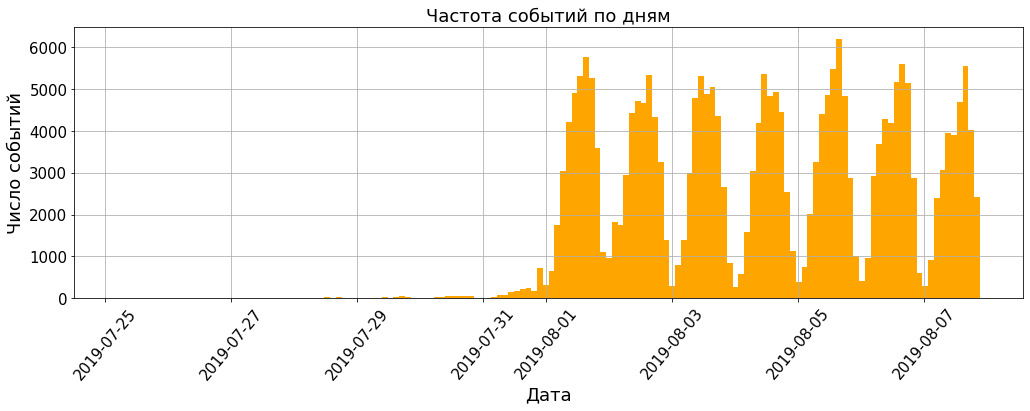

In [13]:
plt.figure(figsize=(17,5))
plot = logs['datetime'].hist(bins = 150, color = 'orange')
for label in (plot.get_xticklabels() + plot.get_yticklabels()):
    label.set_fontsize(15)
plt.title('Частота событий по дням', fontsize = 18)
plt.xlabel('Дата', fontsize = 18)
plt.ylabel('Число событий', fontsize = 18)
plt.xticks(rotation = 50);

До 31 июля данных крайне мало. Большое количество данных появляется с 1 августа. В этих данных наблюдается суточная закономерность: рост числа событий к середине дня и уменьшение к завершению.
Имеет смысл исключить из лога даннные, полученные до 2019-07-31  23:59:59 (1564617599 UNIX)

In [14]:
cor_logs = logs.query('event_timestamp > 1564617599')
print('В логе приведены события, происходившие с {0} по {1}. Продолжительность {2} дней.'.
      format(
          cor_logs['date'].min(),
          cor_logs['date'].max(),
          (cor_logs['datetime'].max() - cor_logs['datetime'].min()).days
))

В логе приведены события, происходившие с 2019-08-01 по 2019-08-07. Продолжительность 6 дней.


In [15]:
print('Потери количества событий после удаления части данных: {:.1%}'.
      format(
          (event_total - cor_logs.shape[0])/event_total
      )
)
print('Потери количества пользователей после удаления части данных: {:.1%}'.
      format(
          (users_total - len(cor_logs['device_id'].unique()))/users_total
      )
)

Потери количества событий после удаления части данных: 1.2%
Потери количества пользователей после удаления части данных: 0.2%


Потери количества событий и пользователей несущественные.

In [16]:
# списки уникальных пользователей из групп A1 и A2 (246, 247) и B (248)
group_246_users = cor_logs.query('exp_id == 246')['device_id'].unique()
group_247_users = cor_logs.query('exp_id == 247')['device_id'].unique()
group_248_users = cor_logs.query('exp_id == 248')['device_id'].unique()

In [17]:
print('Количество уникальных пользователей в группе 246: {0}, в группе 247: {1}, в группе 248: {2}'.
      format(
          len(group_246_users),
          len(group_247_users),
          len(group_248_users)
      )
)

Количество уникальных пользователей в группе 246: 2484, в группе 247: 2513, в группе 248: 2537


In [18]:
# проверка системы деления пользователей
counter = 0
for element in group_246_users:
    if element in group_247_users:
        counter += 1
print('Найдено {} совпадений уникальных пользователей в группах 246 и 247'.
      format(counter)
)

Найдено 0 совпадений уникальных пользователей в группах 246 и 247


In [19]:
counter = 0
for element in group_247_users:
    if element in group_248_users:
        counter += 1
print('Найдено {} совпадений уникальных пользователей в группах 247 и 248'.
      format(counter)
)

Найдено 0 совпадений уникальных пользователей в группах 247 и 248


In [20]:
counter = 0
for element in group_246_users:
    if element in group_248_users:
        counter += 1
print('Найдено {} совпадений уникальных пользователей в группах 246 и 248'.
      format(counter)
)

Найдено 0 совпадений уникальных пользователей в группах 246 и 248


Пользователи во всех группах уникальны.
### Выводы
1. В логе обнаружены полные дубликаты событий. Некоторые события отображены в логе дважды или трижды
2. События до 01.08.2019 00:00:00 исключены в виду их немногочисленности (1,2 % от всего объема данных); кроме того эти события не подчинялись какой-либо закомерности, как данные с 1 августа: с явно выраженными пиками и спадами примерно в одно и тоже время суток
3. Совпадения групп по пользователям отсутствует

## Воронка событий
### Cобытия, их количество и частота

In [21]:
# варианты событий, их частота
events = cor_logs['event_name'].value_counts().reset_index()
events.columns = ['event_name','events_number']
events_sum = events['events_number'].sum()
events['freq'] = events['events_number']/events_sum
events

,event_name,events_number,freq
0,MainScreenAppear,117328,0.487067
1,OffersScreenAppear,46333,0.192343
2,CartScreenAppear,42303,0.175613
3,PaymentScreenSuccessful,33918,0.140805
4,Tutorial,1005,0.004172


'MainScreenAppear' - отображение главной страницы
'OffersScreenAppear' - отображение страницы предложения 
'CartScreenAppear' - отображение страницы корзины
'PaymentScreenSuccessful' - отображение страницы успешной оплаты
'Tutorial' - инструкция

In [22]:
event_dict = {
    'MainScreenAppear' : 'главная страница',
    'OffersScreenAppear' : 'страница товара',
    'CartScreenAppear' : 'корзина',
    'PaymentScreenSuccessful' : 'успешная оплата',
    'Tutorial' : 'справка'
}
events['russian_event'] = events['event_name'].map(event_dict)
events

,event_name,events_number,freq,russian_event
0,MainScreenAppear,117328,0.487067,главная страница
1,OffersScreenAppear,46333,0.192343,страница товара
2,CartScreenAppear,42303,0.175613,корзина
3,PaymentScreenSuccessful,33918,0.140805,успешная оплата
4,Tutorial,1005,0.004172,справка


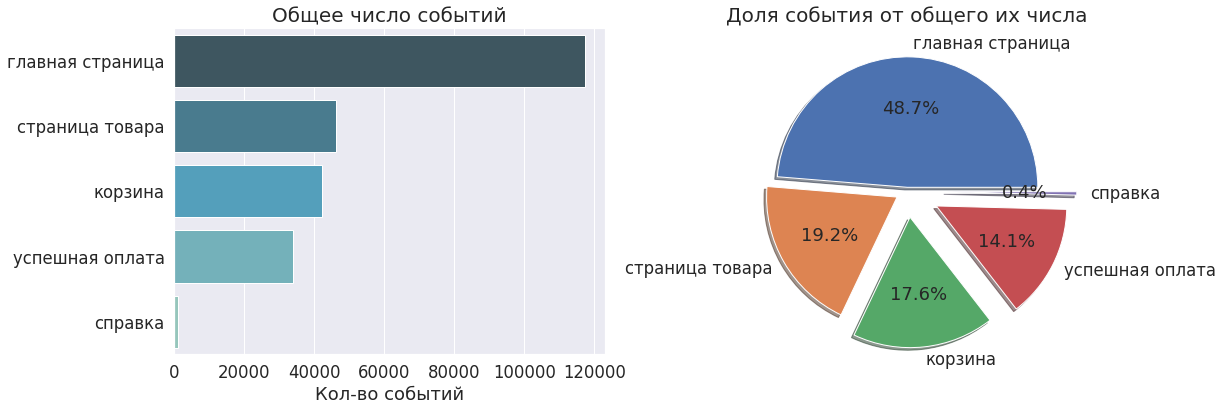

In [23]:
plt.subplots(figsize = (17,6))
sns.set(font_scale = 1.5)
plot = sns.barplot(
    y = 'russian_event',
    x = 'events_number',
    data = events,
    ci = None,
    palette = 'GnBu_d',
    ax = plt.subplot(1,2,1)
)
plt.ylabel('')
plt.xlabel('Кол-во событий')
plt.title('Общее число событий',fontsize = 20);
plot = events[['russian_event','freq']].set_index('russian_event').plot(
    kind = 'pie',
    autopct = '%1.1f%%',
    title='',
    y = 'freq',
    explode = (0.03, 0.09, 0.2, 0.25, 0.3),
    legend = False,
    shadow = True,
    ax = plt.subplot(1,2,2)
)
plt.ylabel('')
plt.title('Доля события от общего их числа', fontsize = 20);

Наиболее частое событие - Просмотр главной страницы. Наиболее редкое - просмотр справки.

### Количество пользователей, совершавших события

In [24]:
events_per_user = cor_logs.groupby('event_name')['device_id'].nunique().to_frame().reset_index()
events_per_user.columns = ['event_name','users_number']
events_per_user['russian_event'] = events_per_user['event_name'].map(event_dict)
events_per_user['ratio'] = events_per_user['users_number'] / cor_logs['device_id'].nunique()
events_per_user = events_per_user.sort_values(by = 'users_number', ascending = False).reset_index(
                                                                                    drop = True)
events_per_user['ratio'] = events_per_user['ratio'].apply(lambda x: '{:.1%}'.format(x))
events_per_user

,event_name,users_number,russian_event,ratio
0,MainScreenAppear,7419,главная страница,98.5%
1,OffersScreenAppear,4593,страница товара,61.0%
2,CartScreenAppear,3734,корзина,49.6%
3,PaymentScreenSuccessful,3539,успешная оплата,47.0%
4,Tutorial,840,справка,11.1%


В столбце 'ratio' отображено процентное отношение числа пользователей, совершивших просмотр определенной страницы к общему числу пользователей. 1,5 % аудитории не видели даже главную страницу. Вероятно, это какая-то ошибка в записи лога.

In [56]:
fig = go.Figure(data = [go.Bar(x = events_per_user['russian_event'], 
                               y = events_per_user['users_number'],
                               text = events_per_user['ratio'],
                               textposition = 'inside',
                               textfont = dict(
                                   size = 16,
                                   color = 'red'
                               )
                              )
                       ]
               )
fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.6)
fig.update_layout(
    title_text='Количество и доля пользователей, совершавших события', 
    yaxis = dict(
        tickfont_size = 16,
        title = go.layout.yaxis.Title(
            text= 'Количество уникальных пользователей',
            font_size = 14
        )
    ),
    xaxis = dict(
        tickfont_size = 14
    )
)
fig.show()

События "Просмотр Главной страницы" -> "Просмотр Страницы товара" -> "Просмотр Страницы корзины" -> "Просмотр страницы Успешная оплата" последовательно укладываются в одну цепочку. 

Событие "Просмотр Справки" непосредственно в цепочку, приводящую к продаже, не входит

### Воронка событий

In [26]:
events_per_user['prev_st_users_number'] = events_per_user['users_number'].shift(1)
events_per_user['ratio_per_previous_stage'] = events_per_user[
    'users_number'] / events_per_user['prev_st_users_number']

In [27]:
funnel = events_per_user[['russian_event','ratio_per_previous_stage']]
funnel = funnel.drop([4]).fillna(1)
funnel['ratio_per_previous_stage'] = funnel['ratio_per_previous_stage'].apply(
    lambda x: '{:.1%}'.format(x)
)
funnel

,russian_event,ratio_per_previous_stage
0,главная страница,100.0%
1,страница товара,61.9%
2,корзина,81.3%
3,успешная оплата,94.8%


In [28]:
# воронка событий средствами plotly
fig = go.Figure(
    go.Funnel(
        y = events_per_user['russian_event'][:-1],
        x = events_per_user['users_number'][:-1],
        textposition = 'inside',
        textinfo = 'percent initial',
        opacity = 0.65, 
        marker = {'color': ['deepskyblue', 'tan', 'teal', 'gold'],
                  'line': {'width': [4, 2, 3, 1, 1],
                           'color': ['wheat', 'wheat', 'wheat', 'blue']}},
        connector = {'line': {'color': 'royalblue', 
                              'dash': 'dot',
                              'width': 3}}
    )
)
fig.update_layout(
    title_text='Воронка событий'
)
fig.show()

Наибольшее число пользователей теряется на этапе Главная страница -> Страница товара. Около 62 % пользователей, видивших Главную страницу, преодолевают этот рубеж. Далее ситуация улучшается. Конверсия из события Просмотр страницы товара -> Корзина составляет 81 %, а из Корзины -> Успешная оплата - почти 95 %.

До успешной оплаты доходит около 47 % от пользователей, увидевших Главную страницу.

## Результаты A/B - теста
### Кол-во пользователей в каждой группе

In [29]:
group_users_number = pd.DataFrame(
    data = [
        len(group_246_users),
        len(group_247_users),
        len(group_248_users)
    ],
    index = cor_logs['exp_id'].unique(),
    columns = ['users_number']
)
group_users_number.index.name = 'group'

In [30]:
group_users_number

,users_number
group,
246,2484
247,2513
248,2537


### Значимые статистические отличия выборок
#### Подготовка данных для тестирования

In [31]:
#подготовка данных из 246 группы
events_group_246 = cor_logs.query(
    'exp_id == 246').groupby(
    'event_name')['device_id'].nunique().to_frame().reset_index()

events_group_246.columns = ['event_name','N_group_246']

events_group_246 = events_group_246.sort_values(
    by = 'N_group_246',
    ascending = False
).reset_index(
    drop = True)

In [32]:
#подготовка данных из 247 группы
events_group_247 = cor_logs.query(
    'exp_id == 247').groupby(
    'event_name')['device_id'].nunique().to_frame().reset_index()

events_group_247.columns = ['event_name','N_group_247']

events_group_247 = events_group_247.sort_values(
    by = 'N_group_247',
    ascending = False
).reset_index(
    drop = True)

In [33]:
#подготовка данных из 246 и 247 группы (группа АА)
events_group_AA = cor_logs.query(
    'exp_id == 246 or exp_id == 247').groupby(
    'event_name')['device_id'].nunique().to_frame().reset_index()

events_group_AA.columns = ['event_name','N_group_AA']

events_group_AA = events_group_AA.sort_values(
    by = 'N_group_AA',
    ascending = False
).reset_index(
    drop = True)

In [34]:
#подготовка данных из 248 группы
events_group_248 = cor_logs.query(
    'exp_id == 248').groupby(
    'event_name')['device_id'].nunique().to_frame().reset_index()

events_group_248.columns = ['event_name','N_group_248']

events_group_248 = events_group_248.sort_values(
    by = 'N_group_248',
    ascending = False
).reset_index(
    drop = True)

In [35]:
# функция для подготовки данных для z-теста

def data_preparing(N_group_A, N_group_B, len_group_A, len_group_B):
    group_A_ratio = N_group_A / len_group_A
    group_B_ratio = N_group_B / len_group_B
    comb_ratio = (N_group_A + N_group_B) / (len_group_A + len_group_B)
    difference = (N_group_A / len_group_A) - (N_group_B / len_group_B)
    return group_A_ratio, group_B_ratio, comb_ratio, difference

In [36]:
# функция для z-тестa
# гипотеза о равенстве долей отвергается (False) или не отвергается (True)
# выводится также p-value

def z_test(difference, comb_ratio, len_group_A, len_group_B, alpha):
    distr = st.norm(0,1)
    z_value = difference / mth.sqrt(
        comb_ratio * (1 - comb_ratio) * (1/len_group_A + 1/len_group_B)
        )
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    if p_value < alpha:
        return 'False', p_value
    else:
        return 'True', p_value

#### A/A - тест
Группы 246 и 247 - контрольные для проверки корректности механизмов и расчетов.

Разница в количестве пользователей:

In [37]:
group_users_number[
    'ratio_per_246'] = (len(group_246_users) - group_users_number['users_number'])/len(group_246_users)
group_users_number[
    'ratio_per_247'] = (len(group_247_users) - group_users_number['users_number'])/len(group_247_users) 
group_users_number[
    'ratio_per_248'] = (len(group_248_users) - group_users_number['users_number'])/len(group_248_users)
group_users_number['ratio_per_246'] = group_users_number['ratio_per_246'].apply(
    lambda x: '{:.1%}'.format(x)
)
group_users_number['ratio_per_247'] = group_users_number['ratio_per_247'].apply(
    lambda x: '{:.1%}'.format(x)
)
group_users_number['ratio_per_248'] = group_users_number['ratio_per_248'].apply(
    lambda x: '{:.1%}'.format(x)
)
group_users_number

,users_number,ratio_per_246,ratio_per_247,ratio_per_248
group,,,,
246,2484,0.0%,1.2%,2.1%
247,2513,-1.2%,0.0%,0.9%
248,2537,-2.1%,-1.0%,0.0%


Отличие количества пользователей в группах довольно существенное. 
Разница в численностях контрольных групп составляет 1,2 %, что превышает 1 %. 

Проверка гипотезы о равенстве долей посетителей, совершивших каждое из действий (относительно общего числа пользователей в группе) 

In [38]:
# фрейм со группами сравнения - 246 и 247
AA_test_data = events_group_246.merge(events_group_247, on = 'event_name')

# переименование столбцов, т.к в функции группы сравнения отмечаются как A и B
# 246 группа - группа А, 247 группа - группа В

AA_test_data.columns = ['event_name','N_group_A','N_group_B']

In [39]:
# получение требующихся для теста данных
(AA_test_data['group_A_ratio'], 
 AA_test_data['group_B_ratio'], 
 AA_test_data['comb_ratio'], 
 AA_test_data['difference']
) = zip(*(AA_test_data.apply(lambda row:
                             data_preparing(
                                 row['N_group_A'],
                                 row['N_group_B'],
                                 len(group_246_users),
                                 len(group_247_users)
                             ), axis = 1
                            )
         )
       )

In [40]:
AA_test_data

,event_name,N_group_A,N_group_B,group_A_ratio,group_B_ratio,comb_ratio,difference
0,MainScreenAppear,2450,2476,0.986312,0.985277,0.985791,0.001036
1,OffersScreenAppear,1542,1520,0.620773,0.604855,0.612768,0.015918
2,CartScreenAppear,1266,1238,0.509662,0.492638,0.501101,0.017024
3,PaymentScreenSuccessful,1200,1158,0.483092,0.460804,0.471883,0.022288
4,Tutorial,278,283,0.111916,0.112614,0.112267,-0.000698


In [41]:
alpha = 0.05

In [42]:
# z - тест
(AA_test_data['test_result'],
 AA_test_data['p_value']    
) = zip(*(AA_test_data.apply(lambda row:
                             z_test(
                                 row['difference'],
                                 row['comb_ratio'],
                                 len(group_246_users),
                                 len(group_247_users),
                                 alpha
                             ), axis = 1
                            )
         )
       )

In [43]:
AA_test_data['event_russian'] = AA_test_data['event_name'].map(event_dict)
AA_test_data[[
    'event_russian',
    'group_A_ratio',
    'group_B_ratio',
    'difference',
    'test_result',
    'p_value'
]]

,event_russian,group_A_ratio,group_B_ratio,difference,test_result,p_value
0,главная страница,0.986312,0.985277,0.001036,True,0.757060
1,страница товара,0.620773,0.604855,0.015918,True,0.248095
2,корзина,0.509662,0.492638,0.017024,True,0.228834
3,успешная оплата,0.483092,0.460804,0.022288,True,0.114567
4,справка,0.111916,0.112614,-0.000698,True,0.937700


Гипотеза о равенстве долей в выборках не может быть отвергнута. При уровне значимости 0,05 можно утверждать, что при отличий в метриках контрольных групп нет. 

Ранее было определено, что пользователи в группах 246 и 247 уникальны, т.е переходы из одной группы в другую в течение эксперимента не наблюдались.

Существует только замечание по количественному распределению - разница в числе пользователей в группах 246 и 247 составляет 1,2 %

### A/B-тест
#### Группа 246 - 248

In [44]:
# фрейм со группами сравнения - 246 и 248
AB_test_I_data = events_group_246.merge(events_group_248, on = 'event_name')

# переименование: группа 246 = группа А, группа 248 = группа В  

AB_test_I_data.columns = ['event_name','N_group_A','N_group_B']

AB_test_I_data

,event_name,N_group_A,N_group_B
0,MainScreenAppear,2450,2493
1,OffersScreenAppear,1542,1531
2,CartScreenAppear,1266,1230
3,PaymentScreenSuccessful,1200,1181
4,Tutorial,278,279


In [45]:
# получение требующихся для теста данных
(AB_test_I_data['group_A_ratio'], 
 AB_test_I_data['group_B_ratio'], 
 AB_test_I_data['comb_ratio'], 
 AB_test_I_data['difference']
) = zip(*(AB_test_I_data.apply(lambda row:
                               data_preparing(
                                   row['N_group_A'],
                                   row['N_group_B'],
                                   len(group_246_users),
                                   len(group_248_users)
                               ), axis = 1
                              )
         )
       )

In [46]:
# z - тест
(AB_test_I_data['test_result'],
 AB_test_I_data['p_value']    
) = zip(*(AB_test_I_data.apply(lambda row:
                               z_test(
                                   row['difference'],
                                   row['comb_ratio'],
                                   len(group_246_users),
                                   len(group_248_users),
                                   alpha
                               ), axis = 1
                              )
         )
       )

In [47]:
# вывод результатов
AB_test_I_data['event_russian'] = AB_test_I_data['event_name'].map(event_dict)
AB_test_I_data[[
    'event_russian',
    'group_A_ratio',
    'group_B_ratio',
    'difference',
    'test_result',
    'p_value'
]]

,event_russian,group_A_ratio,group_B_ratio,difference,test_result,p_value
0,главная страница,0.986312,0.982657,0.003656,True,0.294972
1,страница товара,0.620773,0.603469,0.017304,True,0.208362
2,корзина,0.509662,0.484825,0.024837,True,0.078429
3,успешная оплата,0.483092,0.465510,0.017581,True,0.212255
4,справка,0.111916,0.109972,0.001944,True,0.826429


Гипотеза о равенстве долей по всем событиям не может быть отвергнута: при уровне значимости 0,05 изменение шрифта не приводит к изменению пропорций воронки событий.


#### Группа 247-248

In [48]:
# фрейм со группами сравнения - 247 и 248
AB_test_II_data = events_group_247.merge(events_group_248, on = 'event_name')

# переименование: группа 247 = группа А, группа 248 = группа В  

AB_test_II_data.columns = ['event_name','N_group_A','N_group_B']

AB_test_II_data

,event_name,N_group_A,N_group_B
0,MainScreenAppear,2476,2493
1,OffersScreenAppear,1520,1531
2,CartScreenAppear,1238,1230
3,PaymentScreenSuccessful,1158,1181
4,Tutorial,283,279


In [49]:
# получение требующихся для теста данных
(AB_test_II_data['group_A_ratio'], 
 AB_test_II_data['group_B_ratio'], 
 AB_test_II_data['comb_ratio'], 
 AB_test_II_data['difference']
) = zip(*(AB_test_II_data.apply(lambda row:
                               data_preparing(
                                   row['N_group_A'],
                                   row['N_group_B'],
                                   len(group_247_users),
                                   len(group_248_users)
                               ), axis = 1
                              )
         )
       )

In [50]:
# z - тест
(AB_test_II_data['test_result'],
 AB_test_II_data['p_value']    
) = zip(*(AB_test_II_data.apply(lambda row:
                               z_test(
                                   row['difference'],
                                   row['comb_ratio'],
                                   len(group_247_users),
                                   len(group_248_users),
                                   alpha
                               ), axis = 1
                              )
         )
       )

In [51]:
# вывод результатов
AB_test_II_data['event_russian'] = AB_test_II_data['event_name'].map(event_dict)
AB_test_II_data[[
    'event_russian',
    'group_A_ratio',
    'group_B_ratio',
    'difference',
    'test_result',
    'p_value'
]]

,event_russian,group_A_ratio,group_B_ratio,difference,test_result,p_value
0,главная страница,0.985277,0.982657,0.002620,True,0.458705
1,страница товара,0.604855,0.603469,0.001386,True,0.919782
2,корзина,0.492638,0.484825,0.007814,True,0.578620
3,успешная оплата,0.460804,0.465510,-0.004707,True,0.737342
4,справка,0.112614,0.109972,0.002642,True,0.765324


Гипотеза о равенстве долей по всем событиям не может быть отвергнута
#### Группа 246-247 и 248

In [52]:
AB_test_III_data = events_group_AA.merge(events_group_248, on = 'event_name')

# объединенная группа 246-247 = группа A, группа 248 = группа В
AB_test_III_data.columns = ['event_name','N_group_A','N_group_B']

In [53]:
# получение требующихся для теста данных
(AB_test_III_data['group_A_ratio'], 
 AB_test_III_data['group_B_ratio'], 
 AB_test_III_data['comb_ratio'], 
 AB_test_III_data['difference']
) = zip(*(AB_test_III_data.apply(lambda row:
                               data_preparing(
                                   row['N_group_A'],
                                   row['N_group_B'],
                                   len(group_246_users) + len(group_247_users),
                                   len(group_248_users)
                               ), axis = 1
                              )
         )
       )

In [54]:
# z - тест
(AB_test_III_data['test_result'],
 AB_test_III_data['p_value']    
) = zip(*(AB_test_III_data.apply(lambda row:
                               z_test(
                                   row['difference'],
                                   row['comb_ratio'],
                                   len(group_246_users) + len(group_247_users),
                                   len(group_248_users),
                                   alpha
                               ), axis = 1
                              )
         )
       )

In [55]:
# вывод результатов
AB_test_III_data['event_russian'] = AB_test_III_data['event_name'].map(event_dict)
AB_test_III_data[[
    'event_russian',
    'group_A_ratio',
    'group_B_ratio',
    'difference',
    'test_result',
    'p_value'
]]

,event_russian,group_A_ratio,group_B_ratio,difference,test_result,p_value
0,главная страница,0.985791,0.982657,0.003135,True,0.294245
1,страница товара,0.612768,0.603469,0.009299,True,0.434255
2,корзина,0.501101,0.484825,0.016276,True,0.181759
3,успешная оплата,0.471883,0.465510,0.006373,True,0.600429
4,справка,0.112267,0.109972,0.002295,True,0.764862


Гипотеза о равенстве долей по всем событиям не может быть отвергнута

## Выводы
1. Необходимо откорректировать систему формирования лога: обнаружены дубликаты событий. Часть событий исключена из лога по признаку нехарактерной численности и отсутствию суточных закономерностей
2. Механизм деления пользователей на группы также необходимо улучшить: в А/А тесте разница численности контрольных групп составила 1,2 %;
3. Основная часть пользователей теряется на участке Главная страница - Страница товара - около 40 %. Конверсия в покупателя составляет 47 % от числа видевших Главную страницу;
4. Изменение шрифта не привело к изменению доли пользователей, совершающих события по просмотру страниц. Проведено 20 проверок статистической гипотезы о равенстве выборок с уровнем значимости 0,05. Каждый двадцатый тест может быть ложным.